In [1]:
# Set to have less messages from distributed
import dask
dask.config.set({"logging.distributed": "error"})

In [2]:
from dask.distributed import Client

client = Client("tcp://10.32.10.8:38061")
client

<Client: 'tcp://10.32.10.8:38061' processes=1 threads=2, memory=11.50 GB>

In [3]:
# Load some useful modules 
import numpy as np
import xarray as xr
import xrft
import intake

from matplotlib import pyplot as plt
%matplotlib inline

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [4]:
cat_url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/llc4320.yaml"
cat = intake.Catalog(cat_url)

In [5]:
coords = cat.LLC4320_grid(chunks=False).to_dask().isel(face=1).reset_coords()

In [6]:
coords = coords.chunk({'time':1})

In [7]:
sss = cat.LLC4320_SSS(chunks=False).to_dask().isel(face=1, 
                                                   i = slice(0,200), j = slice(0,200))

In [8]:
sss = sss.SSS.chunk({'time': 360, 'i':200, 'j':200})

In [9]:
sss.data

dask.array<xarray-<this-array>, shape=(9030, 200, 200), dtype=float32, chunksize=(360, 200, 200), chunktype=numpy.ndarray>

In [10]:
subset_factor = 20
sss_sub = (sss.isel(j=slice(0 ,None, subset_factor),
                              i=slice(0 ,None, subset_factor), 
                              time=slice(0,120*24))
                 .stack(point=['i','j'])
                 .chunk({'time': 360, 'point':100}))

In [15]:
sss_sub.load()

KilledWorker: ("('xarray-getitem-79a2309914c27e228073244ab23b9cfe', 3, 0, 0)", <Worker 'tcp://10.32.35.7:39469', memory: 0, processing: 4>)

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/utils.py", line 663, in log_errors
    yield
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/client.py", line 1296, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/utils.py", line 663, in log_errors
    yield
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/client.py", line 1025, in _reconnect
    await self._close()
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/client.py", line 1296, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures

In [12]:
SSS_ps_t = xrft.power_spectrum(sss_sub, dim=['time'],
                           window=True, detrend='constant',
                           chunks_to_segments=True)

In [13]:
SSS_ps_t.data

dask.array<truediv, shape=(8, 360, 100), dtype=float64, chunksize=(1, 360, 100), chunktype=numpy.ndarray>

In [14]:
%time SSS_ps_t.load()

KilledWorker: ("('xarray-getitem-79a2309914c27e228073244ab23b9cfe', 7, 0, 0)", <Worker 'tcp://10.32.36.6:32841', memory: 0, processing: 4>)

In [8]:
# pick a region that is not too close to the poles, here the grid 
# is approximately squarish
sel_area = np.logical_and(np.logical_and(coords.XC>25, coords.XC<45 ),
                           np.logical_and(coords.YC>-55, coords.YC<-49 ))

selg_area = np.logical_and(np.logical_and(coords.XG>25, coords.XG<45 ),
                           np.logical_and(coords.YG>-55, coords.YG<-49 ))


In [9]:
i_sel = coords.XC.where(sel_area, drop=True).i
j_sel = coords.XC.where(sel_area, drop=True).j

In [10]:
ig_sel = coords.XG.where(selg_area, drop=True).i_g
jg_sel = coords.XG.where(selg_area, drop=True).j_g

In [11]:
# Get variables from catalog
sst = cat.LLC4320_SST(chunks=False).to_dask().isel(face=1, i = i_sel, j = j_sel)
sss = cat.LLC4320_SSS(chunks=False).to_dask().isel(face=1, i = i_sel, j = j_sel)
ssh = cat.LLC4320_SSH(chunks=False).to_dask().isel(face=1, i = i_sel, j = j_sel)

In [12]:
u = cat.LLC4320_SSU(chunks=False).to_dask().isel(face=1, i_g = ig_sel, j = jg_sel)
v = cat.LLC4320_SSV(chunks=False).to_dask().isel(face=1, i = ig_sel, j_g = jg_sel)

In [19]:
sst = sst.SST.chunk({'time': 360, 'i':960, 'j':494})

In [45]:
sst.data

dask.array<xarray-<this-array>, shape=(9030, 494, 960), dtype=float32, chunksize=(360, 494, 960), chunktype=numpy.ndarray>

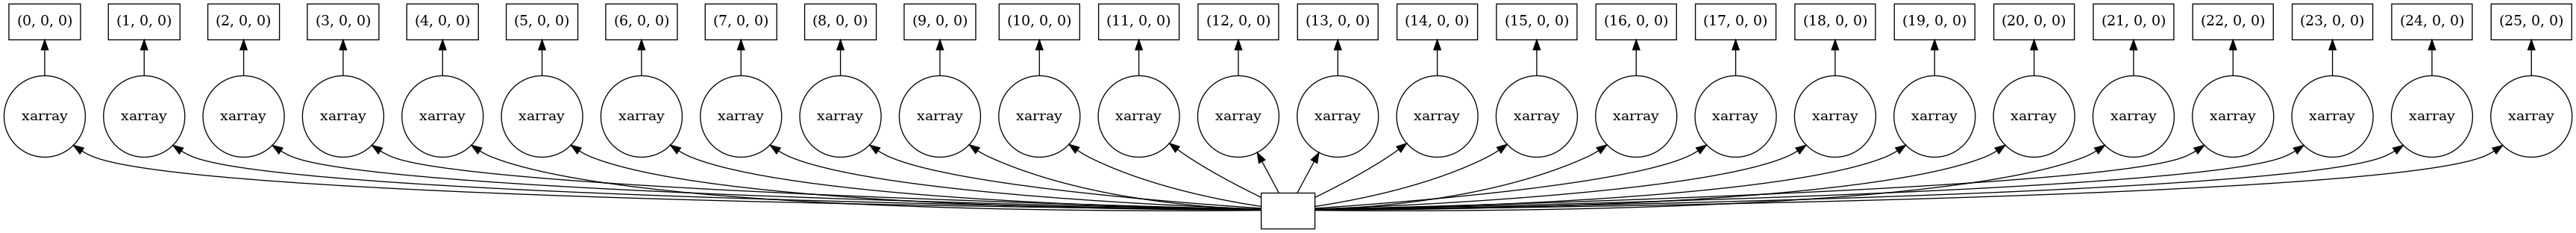

In [35]:
sst.data.visualize()

In [21]:
subset_factor = 20
sst_sub = (sst.isel(j=slice(0 ,None, subset_factor),
                              i=slice(0 ,None, subset_factor), 
                              time=slice(0,30*24))
                 .stack(point=['i','j'])
                 .chunk({'time': 360, 'point':100}))

In [42]:
sst_sub.data

dask.array<rechunk-merge, shape=(720, 1200), dtype=float32, chunksize=(360, 100), chunktype=numpy.ndarray>

In [36]:
sst_sub.data.visualize()

In [26]:
SST_ps_t = xrft.power_spectrum(sst_sub, dim=['time'],
                           window=True, detrend='constant',
                           chunks_to_segments=True)

In [43]:
SST_ps_t.data

dask.array<truediv, shape=(2, 360, 1200), dtype=float64, chunksize=(1, 360, 100), chunktype=numpy.ndarray>

In [34]:
SST_ps_t.data.visualize()

In [28]:
SST_ps_t_av = SST_ps_t.mean(['point','time_segment'])

In [44]:
SST_ps_t_av.data

dask.array<mean_agg-aggregate, shape=(360,), dtype=float64, chunksize=(360,), chunktype=numpy.ndarray>

In [37]:
SST_ps_t_av.data.visualize()

In [38]:
SST_ps_t_av_p = SST_ps_t_av.persist()

In [39]:
SST_ps_t_av_p.load()

<xarray.DataArray 'rechunk-merge-e5e2ad8e4fd9349cb5711668ca8a6de2' (freq_time: 360)>
array([8.39038440e-04, 8.68987008e-04, 8.36389527e-04, 7.85821173e-04,
       8.02571088e-04, 8.22706690e-04, 9.09042936e-04, 8.98234164e-04,
       9.55130640e-04, 9.69352740e-04, 8.19503370e-04, 9.23744086e-04,
       1.04526019e-03, 9.94939703e-04, 1.01892151e-03, 1.20228505e-03,
       1.16975875e-03, 1.22992618e-03, 1.24322481e-03, 1.08704014e-03,
       1.17660303e-03, 1.29646487e-03, 1.26584902e-03, 1.31997361e-03,
       1.31002039e-03, 1.41401138e-03, 1.50789285e-03, 1.59493993e-03,
       1.45407034e-03, 1.49894004e-03, 1.90178918e-03, 1.86134858e-03,
       1.82995264e-03, 2.11120208e-03, 2.02035407e-03, 2.02566863e-03,
       2.29955107e-03, 2.47275251e-03, 2.60603533e-03, 2.42879590e-03,
       2.53245912e-03, 2.90432596e-03, 3.12980509e-03, 3.09703430e-03,
       3.22135384e-03, 3.64742892e-03, 3.68032145e-03, 4.11539906e-03,
       4.74812250e-03, 4.89959873e-03, 5.06815210e-03, 5.47941481e-03,
       5.67616610e-03, 5.64488685e-03, 6.46390288e-03, 6.43066722e-03,
       6.34351915e-03, 6.38715304e-03, 5.94731248e-03, 6.44695520e-03,
       6.94966260e-03, 6.77921220e-03, 7.65893492e-03, 8.01329519e-03,
       9.70646011e-03, 1.06685150e-02, 1.11080787e-02, 1.15429934e-02,
       1.11116606e-02, 1.10070466e-02, 1.18903229e-02, 1.24642582e-02,
       1.31788866e-02, 1.50370467e-02, 1.72909529e-02, 1.99836973e-02,
       2.01628421e-02, 2.11509647e-02, 2.25900232e-02, 2.40742266e-02,
       2.64508703e-02, 2.71583662e-02, 2.88076897e-02, 3.26528493e-02,
       3.30282916e-02, 3.39367887e-02, 3.59793569e-02, 3.68590866e-02,
       3.94478421e-02, 4.48853555e-02, 5.08771155e-02, 5.38679455e-02,
       5.57872885e-02, 5.23140185e-02, 5.58237391e-02, 6.05448799e-02,
       6.97557362e-02, 7.45425893e-02, 7.56645136e-02, 7.64203812e-02,
       8.08467179e-02, 9.70988188e-02, 1.08727236e-01, 1.13729340e-01,
       1.24228631e-01, 1.35979120e-01, 1.33178629e-01, 1.46036350e-01,
       1.54017151e-01, 1.67288794e-01, 1.75025293e-01, 1.95272534e-01,
       2.07994241e-01, 2.24551425e-01, 2.47491673e-01, 2.67139976e-01,
       2.77981122e-01, 2.88787919e-01, 3.09079476e-01, 3.37646532e-01,
       3.58442464e-01, 4.02563325e-01, 4.25994544e-01, 4.32223324e-01,
       4.60438976e-01, 5.06731895e-01, 5.67190460e-01, 5.94418101e-01,
       6.57631588e-01, 6.86944906e-01, 7.20517600e-01, 7.67712325e-01,
       9.31519216e-01, 9.69716930e-01, 1.08504950e+00, 1.28452946e+00,
       1.26654386e+00, 1.30701262e+00, 1.39568927e+00, 1.61961248e+00,
       1.79803099e+00, 1.96541436e+00, 2.08122158e+00, 2.35401741e+00,
       2.71034043e+00, 2.98565755e+00, 3.18383991e+00, 3.59876632e+00,
       4.12634740e+00, 4.85403110e+00, 6.38406905e+00, 5.90725736e+00,
       5.86601169e+00, 6.09785571e+00, 6.52002993e+00, 7.31607559e+00,
       8.02012304e+00, 8.90164270e+00, 9.49848706e+00, 1.10482381e+01,
       1.19787989e+01, 1.32616957e+01, 1.48387388e+01, 1.78851460e+01,
       2.40269212e+01, 3.38890638e+01, 2.91700232e+01, 3.00798189e+01,
       3.49210139e+01, 4.25920533e+01, 4.91382166e+01, 6.20177330e+01,
       8.16474230e+01, 1.08886328e+02, 1.44430746e+02, 2.06855117e+02,
       3.26015000e+02, 5.30701511e+02, 1.46931582e+03, 3.10088963e+03,
       1.17803308e+03, 3.10088963e+03, 1.46931582e+03, 5.30701511e+02,
       3.26015000e+02, 2.06855117e+02, 1.44430746e+02, 1.08886328e+02,
       8.16474230e+01, 6.20177330e+01, 4.91382166e+01, 4.25920533e+01,
       3.49210139e+01, 3.00798189e+01, 2.91700232e+01, 3.38890638e+01,
       2.40269212e+01, 1.78851460e+01, 1.48387388e+01, 1.32616957e+01,
       1.19787989e+01, 1.10482381e+01, 9.49848706e+00, 8.90164270e+00,
       8.02012304e+00, 7.31607559e+00, 6.52002993e+00, 6.09785571e+00,
       5.86601169e+00, 5.90725736e+00, 6.38406905e+00, 4.85403110e+00,
       4.12634740e+00, 3.59876632e+00, 3.18383991e+00, 2.98565755e+00,
       2.71034043e+00, 2.35401741e+00, 2.08122158e+00, 1.96541436e+00,
       1.7

In [40]:
SST_ps_t_av_p

<xarray.DataArray 'rechunk-merge-e5e2ad8e4fd9349cb5711668ca8a6de2' (freq_time: 360)>
array([8.39038440e-04, 8.68987008e-04, 8.36389527e-04, 7.85821173e-04,
       8.02571088e-04, 8.22706690e-04, 9.09042936e-04, 8.98234164e-04,
       9.55130640e-04, 9.69352740e-04, 8.19503370e-04, 9.23744086e-04,
       1.04526019e-03, 9.94939703e-04, 1.01892151e-03, 1.20228505e-03,
       1.16975875e-03, 1.22992618e-03, 1.24322481e-03, 1.08704014e-03,
       1.17660303e-03, 1.29646487e-03, 1.26584902e-03, 1.31997361e-03,
       1.31002039e-03, 1.41401138e-03, 1.50789285e-03, 1.59493993e-03,
       1.45407034e-03, 1.49894004e-03, 1.90178918e-03, 1.86134858e-03,
       1.82995264e-03, 2.11120208e-03, 2.02035407e-03, 2.02566863e-03,
       2.29955107e-03, 2.47275251e-03, 2.60603533e-03, 2.42879590e-03,
       2.53245912e-03, 2.90432596e-03, 3.12980509e-03, 3.09703430e-03,
       3.22135384e-03, 3.64742892e-03, 3.68032145e-03, 4.11539906e-03,
       4.74812250e-03, 4.89959873e-03, 5.06815210e-03, 5.47941481e-03,
       5.67616610e-03, 5.64488685e-03, 6.46390288e-03, 6.43066722e-03,
       6.34351915e-03, 6.38715304e-03, 5.94731248e-03, 6.44695520e-03,
       6.94966260e-03, 6.77921220e-03, 7.65893492e-03, 8.01329519e-03,
       9.70646011e-03, 1.06685150e-02, 1.11080787e-02, 1.15429934e-02,
       1.11116606e-02, 1.10070466e-02, 1.18903229e-02, 1.24642582e-02,
       1.31788866e-02, 1.50370467e-02, 1.72909529e-02, 1.99836973e-02,
       2.01628421e-02, 2.11509647e-02, 2.25900232e-02, 2.40742266e-02,
       2.64508703e-02, 2.71583662e-02, 2.88076897e-02, 3.26528493e-02,
       3.30282916e-02, 3.39367887e-02, 3.59793569e-02, 3.68590866e-02,
       3.94478421e-02, 4.48853555e-02, 5.08771155e-02, 5.38679455e-02,
       5.57872885e-02, 5.23140185e-02, 5.58237391e-02, 6.05448799e-02,
       6.97557362e-02, 7.45425893e-02, 7.56645136e-02, 7.64203812e-02,
       8.08467179e-02, 9.70988188e-02, 1.08727236e-01, 1.13729340e-01,
       1.24228631e-01, 1.35979120e-01, 1.33178629e-01, 1.46036350e-01,
       1.54017151e-01, 1.67288794e-01, 1.75025293e-01, 1.95272534e-01,
       2.07994241e-01, 2.24551425e-01, 2.47491673e-01, 2.67139976e-01,
       2.77981122e-01, 2.88787919e-01, 3.09079476e-01, 3.37646532e-01,
       3.58442464e-01, 4.02563325e-01, 4.25994544e-01, 4.32223324e-01,
       4.60438976e-01, 5.06731895e-01, 5.67190460e-01, 5.94418101e-01,
       6.57631588e-01, 6.86944906e-01, 7.20517600e-01, 7.67712325e-01,
       9.31519216e-01, 9.69716930e-01, 1.08504950e+00, 1.28452946e+00,
       1.26654386e+00, 1.30701262e+00, 1.39568927e+00, 1.61961248e+00,
       1.79803099e+00, 1.96541436e+00, 2.08122158e+00, 2.35401741e+00,
       2.71034043e+00, 2.98565755e+00, 3.18383991e+00, 3.59876632e+00,
       4.12634740e+00, 4.85403110e+00, 6.38406905e+00, 5.90725736e+00,
       5.86601169e+00, 6.09785571e+00, 6.52002993e+00, 7.31607559e+00,
       8.02012304e+00, 8.90164270e+00, 9.49848706e+00, 1.10482381e+01,
       1.19787989e+01, 1.32616957e+01, 1.48387388e+01, 1.78851460e+01,
       2.40269212e+01, 3.38890638e+01, 2.91700232e+01, 3.00798189e+01,
       3.49210139e+01, 4.25920533e+01, 4.91382166e+01, 6.20177330e+01,
       8.16474230e+01, 1.08886328e+02, 1.44430746e+02, 2.06855117e+02,
       3.26015000e+02, 5.30701511e+02, 1.46931582e+03, 3.10088963e+03,
       1.17803308e+03, 3.10088963e+03, 1.46931582e+03, 5.30701511e+02,
       3.26015000e+02, 2.06855117e+02, 1.44430746e+02, 1.08886328e+02,
       8.16474230e+01, 6.20177330e+01, 4.91382166e+01, 4.25920533e+01,
       3.49210139e+01, 3.00798189e+01, 2.91700232e+01, 3.38890638e+01,
       2.40269212e+01, 1.78851460e+01, 1.48387388e+01, 1.32616957e+01,
       1.19787989e+01, 1.10482381e+01, 9.49848706e+00, 8.90164270e+00,
       8.02012304e+00, 7.31607559e+00, 6.52002993e+00, 6.09785571e+00,
       5.86601169e+00, 5.90725736e+00, 6.38406905e+00, 4.85403110e+00,
       4.12634740e+00, 3.59876632e+00, 3.18383991e+00, 2.98565755e+00,
       2.71034043e+00, 2.35401741e+00, 2.08122158e+00, 1.96541436e+00,
       1.7

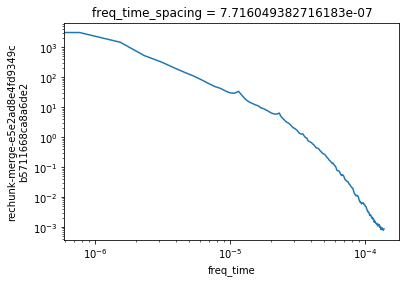

In [41]:
SST_ps_t_av_p.plot()
plt.xscale('log')
plt.yscale('log')

In [ ]:
ds = xr.merge([ssh, sst, sss, u, v])
#ds = llcreader.llcmodel.faces_dataset_to_latlon(ds, metric_vector_pairs=[])

In [8]:
#coords = llcreader.llcmodel.faces_dataset_to_latlon(coords)

In [11]:
print(coords.XC.min().values)
print(coords.XC.max().values)
print(coords.YC.min().values)
print(coords.YC.max().values)

-37.98958206176758
51.98958206176758
-57.00102615356445
13.728165626525879


In [15]:
ds.Eta

<xarray.DataArray 'Eta' (time: 9030, j: 4320, i: 4320)>
[168521472000 values with dtype=float32]
Coordinates:
    face     int64 1
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00

In [ ]:
ds_sel = ds.where(sel_area, drop=True)